## Programming and Maths for AI: Task 1

Let's load our dataset

In [38]:
import pandas as pd
df = pd.read_csv('winequalityN.csv')
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


First, let's count the null values and drop all rows that have null values

In [2]:
df.isna().sum()


type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [39]:
df.dropna(inplace=True)
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Now, we want to check whether the dataset is balanced or not

In [40]:
df['quality'].value_counts()

quality
6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: count, dtype: int64

We notice that this dataset is highly imbalanced and this will result to issues in results. To resolve this issue, we will work only with the 3 highest classes (5,6,7) and we will take 1,000 samples of each to have a balanced dataset

In [45]:
samples = []

for quality in [5, 6, 7]:
    class_rows = df[df['quality'] == quality]
    
    # Sample with replacement if not enough samples
    sampled_rows = class_rows.sample(
        n=2000,
        replace=len(class_rows) < 2000,
        random_state=42
    )
    
    samples.append(sampled_rows)

sampled_df = pd.concat(samples).reset_index(drop=True)

sampled_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,6.3,0.270,0.23,2.90,0.047,13.0,100.0,0.99360,3.28,0.43,9.8,5
1,red,7.5,0.610,0.26,1.90,0.073,24.0,88.0,0.99612,3.30,0.53,9.8,5
2,red,15.5,0.645,0.49,4.20,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
3,white,6.7,0.240,0.41,2.90,0.039,48.0,122.0,0.99052,3.25,0.43,12.0,5
4,red,7.2,0.580,0.03,2.30,0.077,7.0,28.0,0.99568,3.35,0.52,10.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,white,7.1,0.180,0.49,1.30,0.033,12.0,72.0,0.99072,3.05,0.53,11.3,7
5996,white,7.3,0.260,0.33,17.85,0.049,41.5,195.0,1.00000,3.06,0.44,9.1,7
5997,white,6.4,0.230,0.35,4.60,0.039,43.0,147.0,0.99216,3.18,0.40,11.0,7
5998,red,8.5,0.280,0.35,1.70,0.061,6.0,15.0,0.99524,3.30,0.74,11.8,7


Now we need to convert text data to numerical ones. To do so, we will convert white to 0 and red to 1 values

In [46]:
# Map 'type' to numbers
sampled_df['type'] = sampled_df['type'].map({'white': 0, 'red': 1})
sampled_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,6.3,0.270,0.23,2.9,0.047,13.0,100.0,0.99360,3.28,0.43,9.8,5
1,1,7.5,0.610,0.26,1.9,0.073,24.0,88.0,0.99612,3.30,0.53,9.8,5
2,1,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
3,0,6.7,0.240,0.41,2.9,0.039,48.0,122.0,0.99052,3.25,0.43,12.0,5
4,1,7.2,0.580,0.03,2.3,0.077,7.0,28.0,0.99568,3.35,0.52,10.0,5


In [47]:
# Features
X = sampled_df.drop('quality', axis=1)

# Target
y = sampled_df['quality']

As we have lots of features with different scales each, that can affect performance, we will apply Standardization to our data, in order to get a common scale ranging from 0 to 1.

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = y.to_numpy()             # Convert target to NumPy array


### Train test splitting

Stratify- Ensures that the proportion of a target variable's classes is the same in training, testing and testing sets as it was in the original
The dataset has been split into the following manner:
1. Firstly the dataset is split into train and test which 80% for training and 20% for testing maintaining the distribution of the class in each folder using Stratify.
2. Secondly the test data is further split into 10% tetsing and 10% validation dataset again maintaing the distribution of the classes in the dataset .
Overall, the entire dataset is split in the ratio 80:10:10 (80% training, 10% testing and 10% validation)

In [56]:
#splitting the dataset into train and testing which is 80% training and 20% testing
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, shuffle=True, stratify=y
)

# Now splitting the dataset into test and validation where 20% breaks down to 10% test and 10% validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp
)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

Training data: (4800, 12), Validation data: (600, 12), Test data: (600, 12)


Encode output classes to 0,1,2

In [57]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()

y_train = le.fit_transform(y_train)  # 5,6,7 → 0,1,2
y_val   = le.transform(y_val)

print("Original classes:", le.classes_)
print("Encoded labels:", np.unique(y_train))


Original classes: [5 6 7]
Encoded labels: [0 1 2]


#### Activation functions: sigmoid and ReLU

Sigmoid and its derivative

In [58]:
import numpy as np

def sigmoid(x):

    s = 1/(1 + np.exp(-x))

    return s

def derivative_sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    ds = s*(1-s)

    return ds


ReLU and its derivative

In [59]:
def relu(x):
    return x * (x > 0)

def derivative_relu(x):
    return 1 * (x>0)

Now let's implement the softmax function

In [60]:
#def softmax(vector):
#    e = np.exp(vector)
#    return e / e.sum()

# if z is very large, exp(z) can overflow
# solution: subtract by max
def softmax(z): #stable, so we dont have exploding issues due to exp
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


### Implement a fully parametrizable neural network class

## Create a NN class

In [64]:
class NeuralNetwork:

    #hidden layer (sigmoid, relu)
    #output layer (softmax)

    def __init__(self, activation_function, no_of_input_nodes, no_of_hidden_nodes, no_of_output_nodes, n_epochs,
                 lambda1,lambda2,lr,dropout, optimizer, momentum,beta1=0.9,beta2=0.999,eps=1e-8):
        self.hidden_layers = len(no_of_hidden_nodes)
        self.activation_function = activation_function
        self.no_of_input_nodes = no_of_input_nodes # as many as the dataset's features
        self.no_of_hidden_nodes = no_of_hidden_nodes # no fixed number, needs tuning
        self.no_of_output_nodes = no_of_output_nodes # as many as the output classes
        self.n_epochs = n_epochs #no. of epochs to run the NN
        self.lambda1 = lambda1 #lambda variable for L1 regularisation
        self.lambda2 = lambda2 #lambda variable for L2 regularisation
        self.learning_rate = lr #how much to update the weights
        self.z_values = [] # need to store for backprop
        self.a_values = []   # need to store for backprop, first value is the actual data
        self.dropout_masks = [] # save the masks for backprop
        self.dropout = dropout #probability for dropout
        self.weights, self.biases = self.weights_and_bias()
        
        #optimizer settings

        #---momentum SGD---
        self.optimizer = optimizer # the optimizer that will be used
        self.momentum = momentum
        self.vW = [np.zeros_like(W) for W in self.weights]  # velocity for momentum
        self.vb = [np.zeros_like(b) for b in self.biases]

        #---adam---
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # timestep

        self.moment1_W = [np.zeros_like(W) for W in self.weights] # moment1 weight initialization
        self.moment1_b = [np.zeros_like(b) for b in self.biases] # moment1 bias initialization

        self.moment2_W = [np.zeros_like(W) for W in self.weights] # moment2 weight initialization
        self.moment2_b = [np.zeros_like(b) for b in self.biases] # moment2 bias initialization



        

    def weights_and_bias(self):
        layers = [self.no_of_input_nodes] + self.no_of_hidden_nodes + [self.no_of_output_nodes] #e.g. [2,3,5,2]
        weights = [] #TODO: weight and bias proper initialization (xavier)
        biases = []
        for i in range(len((layers))-1):

            n_in = layers[i]
            n_out = layers[i+1]

            weights.append(2*np.random.random((n_in,n_out)) - 1)
            biases.append(np.zeros((1, n_out)))
        return weights, biases
    
    def inverted_dropout(self, x, p):
        # p = dropout probability
        mask = (np.random.rand(*x.shape) > p).astype(float)
        self.dropout_masks.append(mask)
        x_dropped = (x * mask)/(1 - p) # the actual dropout
        
        return x_dropped
    
    def forward_pass(self, X, training=True): #add training flag for dropout

        # Clear previous batch values
        self.a_values = []
        self.z_values = []
        self.dropout_masks = []

        #first hidden layer needs to have the actual data
        #all other hidden layers take the result from the previous layer
        a = X
        self.a_values.append(a) # save for backprop
        
        for layer in range(self.hidden_layers):

            W = self.weights[layer]
            b = self.biases[layer]
            z = np.dot(a, W) + b
            self.z_values.append(z) # save for backprop

            if self.activation_function =='sigmoid':
                a = sigmoid(z)
            elif self.activation_function =='relu':
                a = relu(z)
            #print(f'Shape of layer: {a.shape}')

            #implementing inverted dropout
            if training: # In testing, dropout is not applied
                a = self.inverted_dropout(a, self.dropout) 

            self.a_values.append(a) # save for backprop

        #---Output Layer---
        W = self.weights[-1]
        b = self.biases[-1]
        z = np.dot(a, W) + b
        self.z_values.append(z) # save for backprop
        a = softmax(z)
        self.a_values.append(a) # save for backprop
        #print(f'Shape of output layer: {a.shape}')
        return a
        

    def backward_pass(self, X_train, y_true):
        
        N = y_true.shape[0]

        # We convert labels to one-hot so that they match the shape of y_true
        y_one_hot = np.zeros((N, self.no_of_output_nodes))
        y_one_hot[np.arange(N), y_true] = 1

        # make empty lists for gradients
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)

        # --- Output layer ---
        delta = self.a_values[-1] - y_one_hot  # Derivative of loss: softmax + CE derivative (a(L) - y)
        
        dW[-1] = self.a_values[-2].T.dot(delta) / N

        dW[-1] += self.lambda1 * np.sign(self.weights[-1])   # L1 gradient
        dW[-1] += 2 * self.lambda2 * self.weights[-1]       # L2 gradient


        db[-1] = np.mean(delta, axis=0, keepdims=True) #gradient of bias

        #self.weights[-1] -= self.learning_rate * dW[-1] # update the weight
        #self.biases[-1] -= self.learning_rate * db[-1] # update the bias

        # --- Hidden layers ---
        for layer in range(self.hidden_layers - 1, -1, -1):

            # Backprop error
            delta = delta.dot(self.weights[layer + 1].T)

            #use dropout
            delta *= self.dropout_masks[layer]

            if self.activation_function =='sigmoid':
                delta *= derivative_sigmoid(self.z_values[layer])
            elif self.activation_function =='relu':
                delta *= derivative_relu(self.z_values[layer])
            
            a_prev = X_train if layer == 0 else self.a_values[layer]
            dW[layer] = a_prev.T.dot(delta) / N 
            db[layer] = np.mean(delta, axis=0, keepdims=True) #gradient of bias

            dW[layer] += self.lambda1 * np.sign(self.weights[layer])   # L1 gradient
            dW[layer] += 2 * self.lambda2 * self.weights[layer]       # L2 gradient

            
            #self.weights[layer] -= self.learning_rate * dW[layer] # update the weight
            #self.biases[layer] -= self.learning_rate * db[layer] # update the bias

        self.choose_optimizer(dW, db)




    def compute_loss(self, y_pred, y_true):
        '''
        Cross entropy loss for multi-class classification with L1 and L2 regularization
        '''

        # number of samples
        N = y_true.shape[0]
        
        correct_probs = y_pred[np.arange(N), y_true] #TODO: change to binary formula if dataset is binary

        eps = 1e-15
        correct_probs = np.clip(correct_probs, eps, 1.0) #forces every number to be within a range to exlude 0 where log(0) -> inf

        # loss = average of -log(p) whre p is the predicted probability of the correct class
        loss = -np.sum(np.log(correct_probs)) / N

        l1_loss = self.lambda1 * sum(np.sum(np.abs(W)) for W in self.weights)
        l2_loss = self.lambda2 * sum(np.sum(W**2) for W in self.weights)

        return loss + l1_loss + l2_loss
    
    def choose_optimizer(self, dW, db): # function to call the respective optimizer method to be used
        if self.optimizer == "momentum":
            self.momentum_update(dW, db)
        elif self.optimizer == "adam":
            self.adam_update(dW, db)
        else:
            raise ValueError("Unsupported optimizer")
        
    def momentum_update(self,dW,db):
        for i in range(len(self.weights)):
            self.vW[i] = self.momentum * self.vW[i] + (1 - self.momentum) * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + (1 - self.momentum) * db[i]
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i]  -= self.learning_rate * self.vb[i]

    def adam_update(self,dW,db):
        self.t += 1
        for i in range(len(self.weights)):
            self.moment1_W[i] = self.beta1 * self.moment1_W[i] + (1 - self.beta1) * dW[i]
            self.moment1_b[i] = self.beta1 * self.moment1_b[i] + (1 - self.beta1) * db[i]
            self.moment2_W[i] = self.beta2 * self.moment2_W[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.moment2_b[i] = self.beta2 * self.moment2_b[i] + (1 - self.beta2) * (db[i] ** 2)
            
            mW_hat = self.moment1_W[i] / (1 - self.beta1 ** self.t)
            vW_hat = self.moment2_W[i] / (1 - self.beta2 ** self.t)
            mb_hat = self.moment1_b[i] / (1 - self.beta1 ** self.t)
            vb_hat = self.moment2_b[i] / (1 - self.beta2 ** self.t)
            
            self.weights[i] -= self.learning_rate * mW_hat / (np.sqrt(vW_hat) + self.eps)
            self.biases[i]  -= self.learning_rate * mb_hat / (np.sqrt(vb_hat) + self.eps)


    




In [77]:
#Param tuning:
#lambda1 and lambda 2 can be from 0 to 1

nn = NeuralNetwork(
    activation_function='relu',
    no_of_input_nodes=X_train.shape[1], # input features
    no_of_hidden_nodes=[128,128,128],
    no_of_output_nodes=len(np.unique(y_train)),
    n_epochs=200,
    lambda1=0.0,
    lambda2=0.0,
    lr=0.001,
    dropout=0.2,
    optimizer="adam",
    momentum=0.9
    )

for epoch in range(nn.n_epochs):
    # Forward pass
    y_pred = nn.forward_pass(X_train, training=True)

    # Loss function
    loss = nn.compute_loss(y_pred, y_train)

    # Backward pass
    nn.backward_pass(X_train, y_train)

    if epoch % 5 == 0:
        y_pred_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(y_pred_labels == y_train)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")




Epoch 0, Loss: 22.2192, Accuracy: 0.3262
Epoch 5, Loss: 21.1940, Accuracy: 0.3500
Epoch 10, Loss: 19.6145, Accuracy: 0.3977
Epoch 15, Loss: 18.9432, Accuracy: 0.4142
Epoch 20, Loss: 18.4938, Accuracy: 0.4279
Epoch 25, Loss: 17.9646, Accuracy: 0.4406
Epoch 30, Loss: 18.2410, Accuracy: 0.4281
Epoch 35, Loss: 17.2293, Accuracy: 0.4579
Epoch 40, Loss: 17.4119, Accuracy: 0.4521
Epoch 45, Loss: 16.7695, Accuracy: 0.4610
Epoch 50, Loss: 16.5563, Accuracy: 0.4669
Epoch 55, Loss: 16.9334, Accuracy: 0.4548
Epoch 60, Loss: 16.6825, Accuracy: 0.4600
Epoch 65, Loss: 16.4604, Accuracy: 0.4612
Epoch 70, Loss: 16.1290, Accuracy: 0.4679
Epoch 75, Loss: 16.0195, Accuracy: 0.4642
Epoch 80, Loss: 16.1424, Accuracy: 0.4646
Epoch 85, Loss: 15.7338, Accuracy: 0.4679
Epoch 90, Loss: 15.6137, Accuracy: 0.4675
Epoch 95, Loss: 15.9368, Accuracy: 0.4565
Epoch 100, Loss: 15.2165, Accuracy: 0.4744
Epoch 105, Loss: 14.7484, Accuracy: 0.4888
Epoch 110, Loss: 15.0419, Accuracy: 0.4715
Epoch 115, Loss: 14.8627, Accurac

In [25]:
y_pred = nn.forward_pass(X_train, training=False)
y_pred_labels = np.argmax(y_pred, axis=1)

train_accuracy = np.mean(y_pred_labels == y_train)
print("Training accuracy:", train_accuracy)


Training accuracy: 0.6133333333333333


In [26]:
y_val_pred = nn.forward_pass(X_val, training=False)
y_val_labels = np.argmax(y_val_pred, axis=1)

val_accuracy = np.mean(y_val_labels == y_val)
print("Validation accuracy:", val_accuracy)


Validation accuracy: 0.5566666666666666


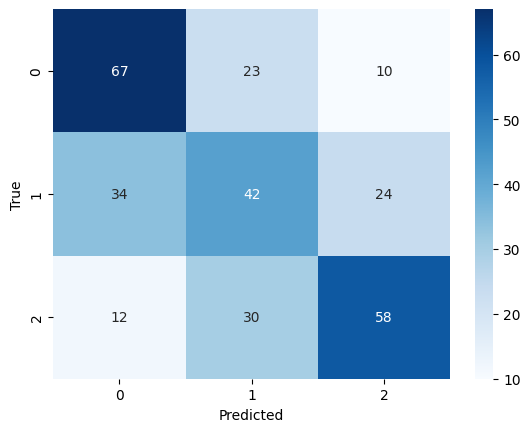

In [34]:
from sklearn.metrics import confusion_matrix

y_val_pred_labels = np.argmax(y_val_pred, axis=1)
cm = confusion_matrix(y_val, y_val_pred_labels)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [16]:
print("Row sum:", np.sum(y_pred[0]))
print("Min prob:", np.min(y_pred))
print("Max prob:", np.max(y_pred))


Row sum: 1.0
Min prob: 0.21191515709254674
Max prob: 0.5148603070902614


### Evaluate different parameters

Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.0001, opt=adam, mom=0.0
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.0001, opt=momentum, mom=0.8
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.0001, opt=momentum, mom=0.9
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.0001, opt=momentum, mom=0.99
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.001, opt=adam, mom=0.0
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.001, opt=momentum, mom=0.8
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.001, opt=momentum, mom=0.9
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.001, opt=momentum, mom=0.99
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.01, opt=adam, mom=0.0
Training: act=sigmoid, hidden=[32, 32], lr=0.001, drop=0.0, l1=0.0, l2=0.01, opt=momentum, mom=0.8
Training

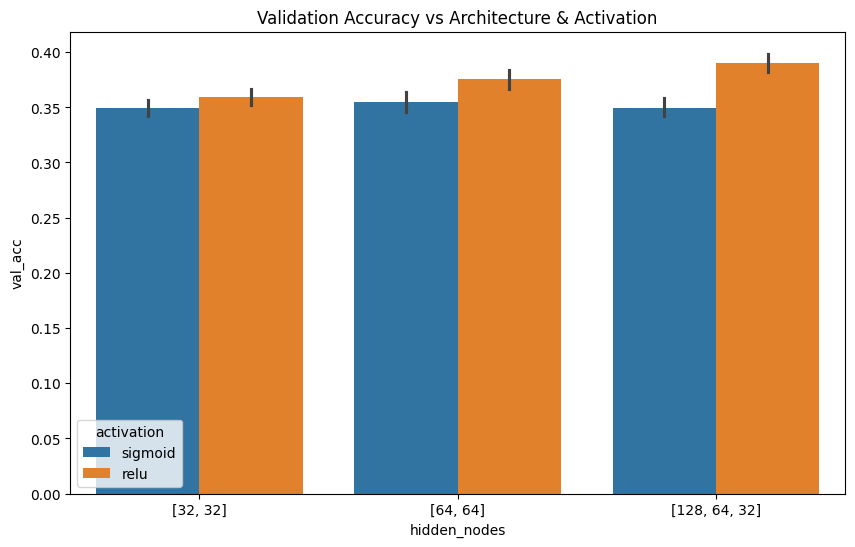

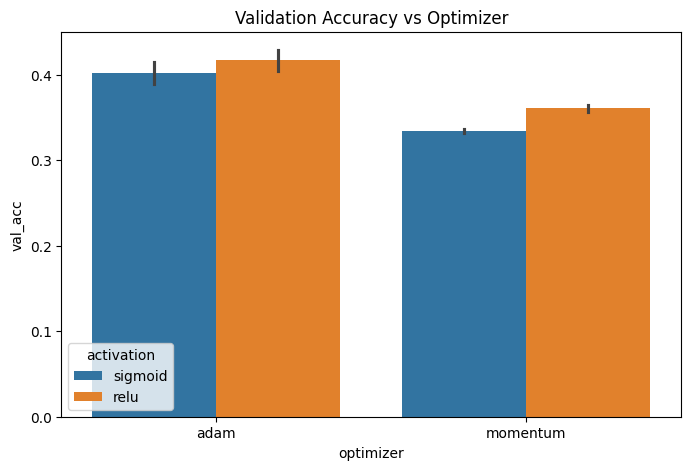

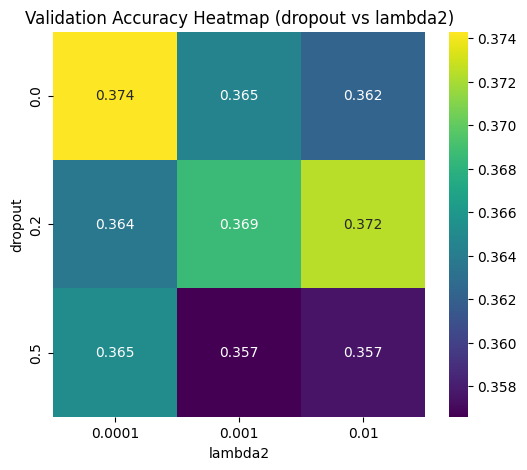

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your NeuralNetwork class is already defined and imported

# -------------------------------
# Define hyperparameter ranges
# -------------------------------
activations = ['sigmoid', 'relu']
hidden_nodes_list = [[32,32], [64,64], [128,64,32]]
learning_rates = [0.001, 0.0001]
dropouts = [0.0, 0.2, 0.5]
lambda1_list = [0.0, 1e-4, 1e-3]
lambda2_list = [0.0,1e-4, 1e-3, 1e-2]
optimizers = ['adam', 'momentum']
momentum_values = [0.8, 0.9, 0.99]

n_epochs = 100  # Adjust if needed

# -------------------------------
# Prepare results storage
# -------------------------------
results = []

# -------------------------------
# Loop over hyperparameter combinations
# -------------------------------
for activation in activations:
    for hidden_nodes in hidden_nodes_list:
        for lr in learning_rates:
            for dropout in dropouts:
                for lambda1 in lambda1_list:
                    for lambda2 in lambda2_list:
                        for optimizer in optimizers:
                            # Momentum is only used for momentum optimizer
                            momentum_opts = momentum_values if optimizer=='momentum' else [0.0]

                            for momentum in momentum_opts:
                                print(f"Training: act={activation}, hidden={hidden_nodes}, lr={lr}, drop={dropout}, l1={lambda1}, l2={lambda2}, opt={optimizer}, mom={momentum}")

                                # Initialize neural network
                                nn = NeuralNetwork(
                                    activation_function=activation,
                                    no_of_input_nodes=X_train.shape[1],
                                    no_of_hidden_nodes=hidden_nodes,
                                    no_of_output_nodes=3,
                                    n_epochs=n_epochs,
                                    lr=lr,
                                    lambda1=lambda1,
                                    lambda2=lambda2,
                                    dropout=dropout,
                                    optimizer=optimizer,
                                    momentum=momentum
                                )

                                # Train the network
                                for epoch in range(n_epochs):
                                    # Forward pass
                                    y_pred_train = nn.forward_pass(X_train, training=True)
                                    # Compute loss
                                    loss = nn.compute_loss(y_pred_train, y_train)
                                    # Backward pass
                                    nn.backward_pass(X_train, y_train)

                                # Evaluate training accuracy
                                y_train_pred = nn.forward_pass(X_train, training=False)
                                y_train_labels = np.argmax(y_train_pred, axis=1)
                                train_acc = np.mean(y_train_labels == y_train)

                                # Evaluate validation accuracy
                                y_val_pred = nn.forward_pass(X_val, training=False)
                                y_val_labels = np.argmax(y_val_pred, axis=1)
                                val_acc = np.mean(y_val_labels == y_val)

                                # Save results
                                results.append({
                                    'activation': activation,
                                    'hidden_nodes': str(hidden_nodes),
                                    'lr': lr,
                                    'dropout': dropout,
                                    'lambda1': lambda1,
                                    'lambda2': lambda2,
                                    'optimizer': optimizer,
                                    'momentum': momentum,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'final_loss': loss
                                })

# -------------------------------
# Convert results to DataFrame
# -------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv("nn_hyperparam_results.csv", index=False)
print("Saved results to nn_hyperparam_results.csv")

# -------------------------------
# Plotting examples
# -------------------------------

# 1. Validation accuracy vs architecture
plt.figure(figsize=(10,6))
sns.barplot(x='hidden_nodes', y='val_acc', hue='activation', data=df_results)
plt.title("Validation Accuracy vs Architecture & Activation")
plt.show()

# 2. Validation accuracy vs optimizer
plt.figure(figsize=(8,5))
sns.barplot(x='optimizer', y='val_acc', hue='activation', data=df_results)
plt.title("Validation Accuracy vs Optimizer")
plt.show()

# 3. Heatmap for dropout and lambda2
subset = df_results[df_results['lambda1']==0.0]
pivot_table = subset.pivot_table(values='val_acc', index='dropout', columns='lambda2')
plt.figure(figsize=(6,5))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title("Validation Accuracy Heatmap (dropout vs lambda2)")
plt.show()


In [68]:
df_results

,activation,hidden_nodes,lr,dropout,lambda1,lambda2,optimizer,momentum,train_acc,val_acc,final_loss
0,sigmoid,"[32, 32]",0.0010,0.0,0.000,0.0001,adam,0.00,0.516458,0.505000,1.038876
1,sigmoid,"[32, 32]",0.0010,0.0,0.000,0.0001,momentum,0.80,0.336458,0.341667,1.667803
2,sigmoid,"[32, 32]",0.0010,0.0,0.000,0.0001,momentum,0.90,0.320208,0.351667,1.667587
3,sigmoid,"[32, 32]",0.0010,0.0,0.000,0.0001,momentum,0.99,0.356250,0.336667,1.227773
4,sigmoid,"[32, 32]",0.0010,0.0,0.000,0.0010,adam,0.00,0.431458,0.436667,1.559892
...,...,...,...,...,...,...,...,...,...,...,...
1291,relu,"[128, 64, 32]",0.0001,0.5,0.001,0.0010,momentum,0.99,0.368125,0.368333,31.387553
1292,relu,"[128, 64, 32]",0.0001,0.5,0.001,0.0100,adam,0.00,0.342917,0.313333,66.278604
1293,relu,"[128, 64, 32]",0.0001,0.5,0.001,0.0100,momentum,0.80,0.326458,0.330000,66.568786
1294,relu,"[128, 64, 32]",0.0001,0.5,0.001,0.0100,momentum,0.90,0.266875,0.266667,67.928583


In [75]:
max(df_results['val_acc'])

0.5733333333333334